In [1]:
from proto import *
from scipy.signal import butter,lfilter,hamming
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

In [4]:
example = np.load('example.npz')['example'].item()
tidigits = np.load('tidigits.npz')['tidigits']

In [5]:
winlen = 400
winshift = 200
x = np.arange(10)

for i in xrange(len(tidigits)):
    samples = tidigits[i]['samples']
    num_frames = int(np.ceil(float(len(samples) - winlen) / winshift))
    frames = np.zeros((num_frames, winlen))
    for i in range(num_frames):
        frames[i] = np.array(samples[(i * winshift):(i * winshift + winlen)])
    pius = np.array(frames)
    if not np.allclose(enframe(samples, winlen, winshift), pius):
        abort()


In [7]:
print example['preemph']
print 'vs'
print proto

[[  1.99993896   0.05999817  -2.93991028 ...,  -0.17999451  -0.17999451
    2.81991394]
 [  2.99990845   1.08996674   1.11996582 ...,   0.          -0.99996948
    1.96993988]
 [ -3.99987793   3.87988159  -0.99996948 ...,  -0.9699704    0.
    0.99996948]
 ..., 
 [ 25.99920654   0.7799762    1.77994568 ...,   2.44992523  -1.48995453
    2.44992523]
 [ -5.99981689  -1.17996399   0.78997589 ...,  -0.9699704    2.99990845
   -0.90997223]
 [ 15.99951172   0.47998535   0.47998535 ...,  -1.23996216   1.7299472
   -3.20990204]]
vs


NameError: name 'proto' is not defined

In [8]:
coeff = 0.97
preemph = lfilter([1, -coeff], 1, example['frames'])
print np.count_nonzero(preemph - example['preemph'])

0


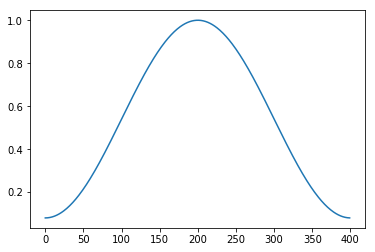

In [9]:
hamming_window = hamming(preemph.shape[1], sym=False)
plt.plot(hamming_window)

In [10]:
windowed = example['preemph'] * hamming_window
print np.allclose(windowed, example['windowed'])

True


In [11]:
from scipy import fftpack

In [12]:
NFFT = 512
spec = np.absolute(fftpack.fft(example['windowed'], NFFT))
spec = np.square(spec)
print np.allclose(spec, example['spec'])

True


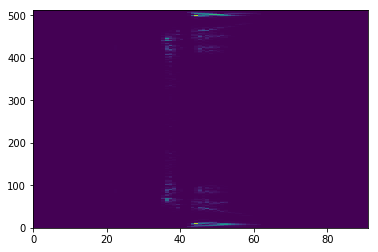

In [13]:
plt.pcolormesh(example['spec'].T)

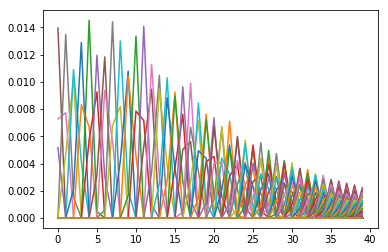

In [14]:
from tools import trfbank
filterbank = trfbank(20e3, NFFT)
plt.plot(filterbank)

True

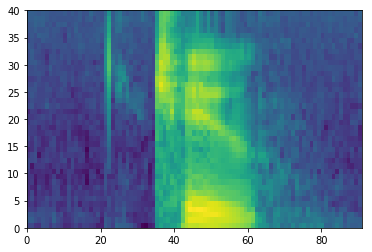

In [15]:
mspec = np.log(example['spec'].dot(filterbank.T))
plt.pcolormesh(mspec.T)
np.allclose(mspec, example['mspec'])

True

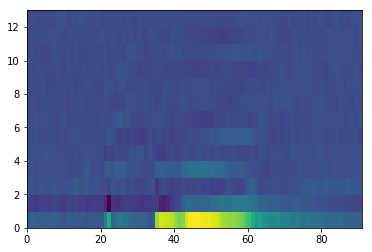

In [16]:
from scipy.fftpack.realtransforms import dct
mfcc = dct(mspec, norm='ortho')[:,:13]
plt.pcolormesh(mfcc.T)
np.allclose(mfcc, example['mfcc'])

TypeError: 'int' object has no attribute '__getitem__'

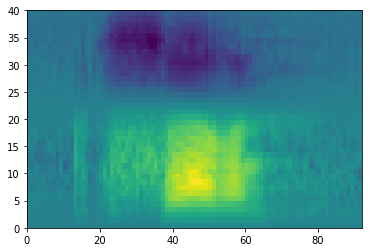

In [93]:
from tools import lifter
plt.pcolormesh(lifter(mfcc).T)
np.allclose(lifter(mfcc), example['lmfcc'])

In [18]:
from proto import mfcc
tidigits = np.load('tidigits.npz')['tidigits']
mfccs = []
for i in range(len(tidigits)):
    samples = tidigits[i]['samples']
    mfccs.append(mfcc(samples))

r = np.concatenate(mfccs)
print r.shape

(3883, 13)


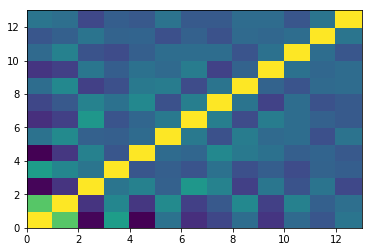

In [19]:
corrcoef = np.corrcoef(r.T)
plt.pcolormesh(corrcoef)

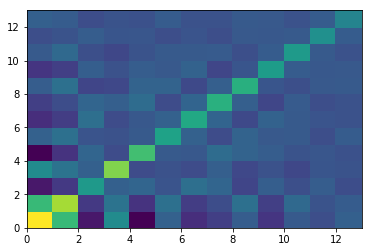

In [20]:
cov = np.cov(r.T)
plt.pcolormesh(cov)

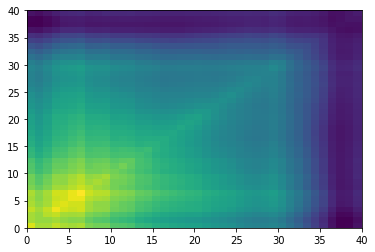

In [74]:
from proto import mfcc
mfccs = []
for i in range(len(tidigits)):
    samples = tidigits[i]['samples']
    mfccs.append(mspec(samples))

r = np.concatenate(mfccs)
cov = np.cov(r.T)
plt.pcolormesh(cov)

In [30]:
def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    r, c = len(x), len(y)
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = np.inf
    D0[1:, 0] = np.inf
    acc_dist = D0[1:, 1:] # view
    for i in range(r):
        for j in range(c):
            #print x[i].shape
            #print y[j].shape
            distance = dist(x[i], y[j])
            #print distance
            acc_dist[i, j] = distance
    local_dist = acc_dist.copy()
    for i in range(r):
        for j in range(c):
            acc_dist[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x) == 1:
        path = np.zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), np.zeros(len(x))
    else:
        path = _traceback(D0)
    return acc_dist[-1, -1] / sum(acc_dist.shape), local_dist, acc_dist, path

def _traceback(D):
    i, j = np.array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = np.argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)


In [31]:
D = np.empty((len(tidigits), len(tidigits)))
from scipy.spatial.distance import cdist
dist = lambda x, y: cdist(x.reshape(1,-1), y.reshape(1,-1))
mfcc1 = mfccs[1]
mfcc2 = mfccs[2]
print mfcc1.reshape(1,-1).shape
print dist(mfcc1[0], mfcc2[0])
for i in xrange(len(D)):
    for j in xrange(len(D)):
        global_dist, local_dist, acc_dist, path = dtw(mfccs[i], mfccs[j], dist)
        D[i,j] = global_dist

(1, 962)
[[ 36.56337753]]


(44, 44)


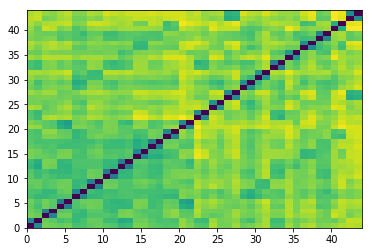

In [32]:
print D.shape
plt.pcolormesh(D)

['man_bm_o_a', 'man_bm_o_b', 'man_bm_z_a', 'man_bm_z_b', 'man_bm_1_a', 'man_bm_1_b', 'man_bm_2_a', 'man_bm_2_b', 'man_bm_3_a', 'man_bm_3_b', 'man_bm_4_a', 'man_bm_4_b', 'man_bm_5_a', 'man_bm_5_b', 'man_bm_6_a', 'man_bm_6_b', 'man_bm_7_a', 'man_bm_7_b', 'man_bm_8_a', 'man_bm_8_b', 'man_bm_9_a', 'man_bm_9_b', 'woman_ew_o_a', 'woman_ew_o_b', 'woman_ew_z_a', 'woman_ew_z_b', 'woman_ew_1_a', 'woman_ew_1_b', 'woman_ew_2_a', 'woman_ew_2_b', 'woman_ew_3_a', 'woman_ew_3_b', 'woman_ew_4_a', 'woman_ew_4_b', 'woman_ew_5_a', 'woman_ew_5_b', 'woman_ew_6_a', 'woman_ew_6_b', 'woman_ew_7_a', 'woman_ew_7_b', 'woman_ew_8_a', 'woman_ew_8_b', 'woman_ew_9_a', 'woman_ew_9_b']


{'color_list': ['g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'b',
  'b'],
 'dcoord': [[0.0, 9.0102221688253259, 9.0102221688253259, 0.0],
  [0.0, 14.264232260895577, 14.264232260895577, 9.0102221688253259],
  [0.0, 5.3303263393439311, 5.3303263393439311, 0.0],
  [0.0, 5.1894780909398888, 5.1894780909398888, 0.0],
  [0.0, 5.7571348473346111, 5.7571348473346111, 0.0],
  [5.1894780909398888,
   10.704796617750487,
   10.704796617750487,
   5.7571348473346111],
  [5.3303263393439311,
   11.198675981183625,
   11.198675981183625,
   10.704796617750487],
  [0.0, 6.6817704331998788, 6.6817704331998788, 0.0],
  [0.0, 7.2115073121059643, 7.2115073121059643, 0.0],
  [6.6817704331998788,
   11.333846382989011,
   11.333846382989011,
   7.2115073121059643],
  

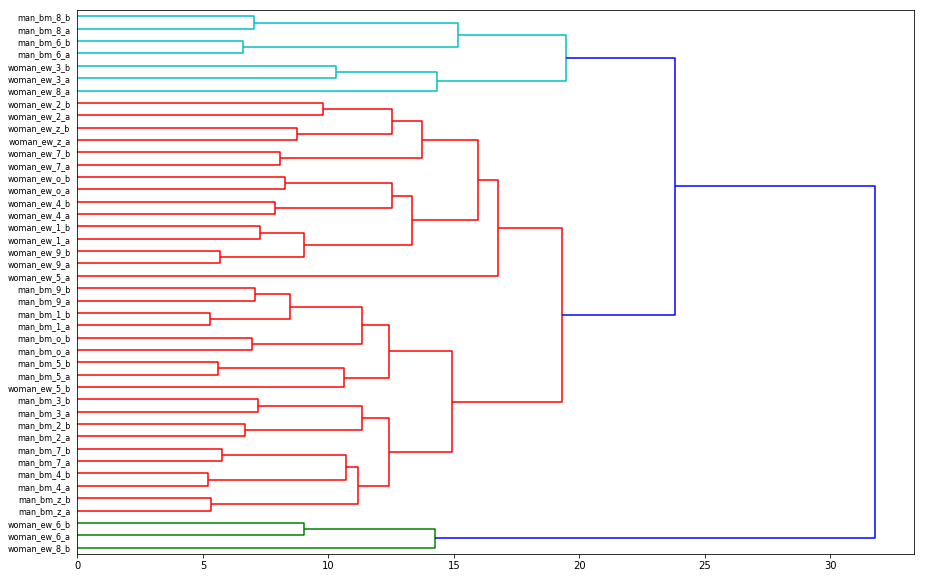

In [75]:
from scipy.cluster.hierarchy import linkage,dendrogram
D_linked = linkage(D.T, method='complete')
plt.figure(figsize=(15,10))
from tools import tidigit2labels
labels = tidigit2labels(tidigits)
print labels
dendrogram(D_linked, labels=labels, orientation='right')

In [62]:
mf = mfcc(tidigits[0]['samples'])
for i in range(1, len(tidigits)):
    samples = tidigits[i]['samples']
    mf = np.vstack([mf, mfcc(samples)])
mf.shape

(3883, 13)

In [86]:
import itertools
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

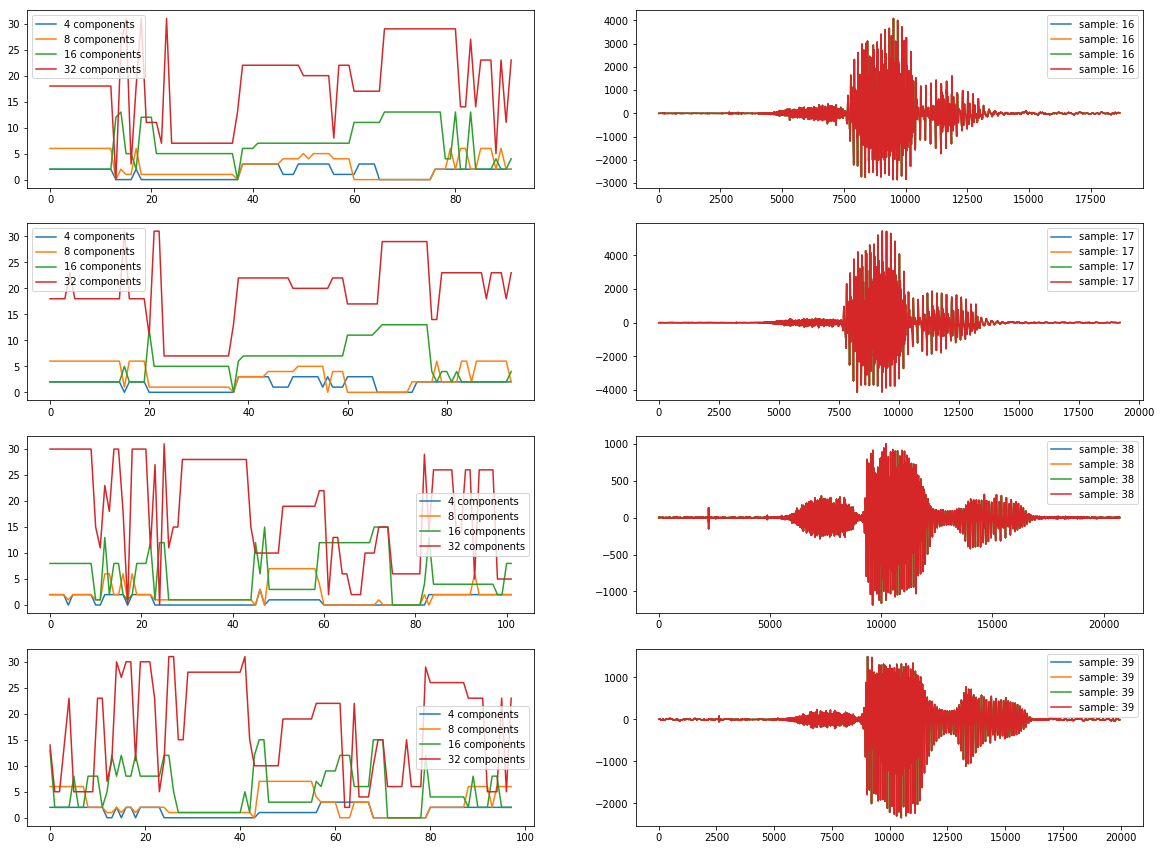

In [134]:
from sklearn.mixture import GaussianMixture
import proto
plt.figure(figsize=(20,15))
for n_components in [4,8,16,32]:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(mf)
    i = 1
    for k in [16,17,38,39]:
        mfcc = proto.mfcc(tidigits[k]['samples'])
        predict = gmm.predict(mfcc)
        ax = plt.subplot(4, 2, i)
        labels = tidigit2labels([tidigits[k]])
        plt.plot(predict, label='%s components' % n_components)
        ax.legend()
        ax = plt.subplot(4, 2, i + 1)
        plt.plot(tidigits[k]['samples'], label='sample: %s' % k)
        i += 2
        ax.legend()